In [5]:
# Import Library
from asyncio.windows_events import NULL
from audioop import mul
from xml.dom import INVALID_MODIFICATION_ERR
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
import random

from sympy import false
#import pandas_techinal_indicators as ta #https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pandas_datareader as web
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold,StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
# Ensure Reproducibility and Readibility
plt.rcParams['figure.figsize'] = (7,4.5)
np.random.seed(423)
random.seed(423)


class Settings:
    def __init__(self) -> None:
        self.trainTestRatio = 0.7
        self.tickers = ["AMD", "AAPL", "EDU", "SHOP","TSLA","GME","GOOGL","KO","NVDA","SMH"]
        self.attributeOfInterest = ["Open","High","Low","Close","Volume"]
        self.stocksOfInterest = {}
        self.indicators = ["MACD","OBV",'PROC',"Stochastic Oscillator"]
        self.indicatorHorizon = 14
setting = Settings()

# Stocks of interest
multpl_stocks = web.get_data_yahoo(setting.tickers,
start = "2016-11-01",
end = "2022-02-25")

stocksOfInterest = {}

# Indicator of interest


# Get Data

# 各种calculator先define上

# Prepare Data
#   Apply Data Smoothing
#   Get All indicators

# Train Model

# 展示结果
#   画图
#   Metrics  




# Data Smoothing Processor---------------------------------------------------
# Not Done, need look into it
def get_exp_preprocessing(df, alpha=0.9):
    edata = df.ewm(alpha=alpha).mean()    
    return edata
# Data Smoothing Processor---------------------------------------------------

def hyptertune(estimator, X_train, y_train, param_grid, X_test):
    grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, njobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    pred = grid_search.predict(X_test)
    return pred

# Data Storage --------------------------------------------------------------
class stock:

    def __init__(self, name) -> None:
        self.name = name
        self.IndicatorHorizon = 14
        self.orig = pd.DataFrame(columns=["Open","High","Low","Close","Volume"])
        self.currentdf = self.orig
        self.smoothed = NULL
        self.currentStat = "Original"
        self.y = []
        self.X = []


    def getSmoothed(self):
        self.smoothed = self.orig
        ts = self.smoothed["Close"].squeeze()
        print(ts)
        fit = SimpleExpSmoothing(ts).fit()
        
        self.smoothed["Close"] = fit.fittedvalues.to_frame()
        print(self.smoothed["Close"] )

    def switch(self):
        if self.currentdf == "Original":
            self.currentdf = self.smoothed
            self.currentStat = "Smoothed"
        else:
            self.currentdf = self.orig
            self.currentStat = "Original"

    def getOBV(self):
        df = self.currentdf
        N = len(df["Close"])
        print("OBV Len:",N)
        i = 0
        OBV = np.zeros(N)
        OBV[0]=0
        while i < (N-1):
            if (df['Close'].values)[i+1] - (df['Close'].values)[i] > 0:
                OBV[i+1] = OBV[i] + (df['Volume'].values)[i+1]
            if (df['Close'].values)[i+1] - (df['Close'].values)[i] == 0:
                OBV[i+1] = OBV[i]
            if (df['Close'].values)[i+1]- (df['Close'].values)[i] < 0:
                OBV[i+1] = OBV[i] - (df['Volume'].values)[i+1]
            i = i + 1
        print("New OBV len:",len(OBV))
        self.orig['OBV'] = OBV

    def getRSI(self):
        df = self.orig["Close"]
        df = df.squeeze()
        n = len(df)
        x0 = df[:n - 1].values
        x1 = df[1:].values
        change = x1 - x0
        avgGain = []
        avgLoss = []
        loss = 0
        gain = 0
        for i in range(self.IndicatorHorizon):
            if change[i] > 0:
                gain += change[i]
            elif change[i] < 0:
                loss += abs(change[i])
        averageGain = gain / self.IndicatorHorizon
        averageLoss = loss / self.IndicatorHorizon
        avgGain.append(averageGain)
        avgLoss.append(averageLoss)
        for i in range(self.IndicatorHorizon, n - 1):
            if change[i] >= 0:
                avgGain.append((avgGain[-1] * 13 + change[i]) / 14.0)
                avgLoss.append((avgLoss[-1] * 13) / 14.0)
            else:
                avgGain.append((avgGain[-1] * 13) / 14.0)
                avgLoss.append((avgLoss[-1] * 13 + abs(change[i])) / 14.0)
        avgGain = np.array(avgGain)
        avgLoss = np.array(avgLoss)
        RS = avgGain / avgLoss
        RSI = 100 - (100 / (1 + RS))
        RSI = np.append(np.zeros(14),RSI)
        self.orig["RSI"] = RSI
        


    def getSO(self):
        df = self.currentdf
        high = df['High']
        low = df['Low']
        close = df['Close']
        N = len(high)
        highestHigh = np.zeros(N)
        highestHigh[0:13] = np.nan
        lowestLow = np.zeros(N)
        lowestLow[0:13] = np.nan
        i = 13
        while i <= (N-1):
            highestHigh[i] = high[i - 13:i + 1].max()
            lowestLow[i] = low[i - 13:i + 1].min()
            i = i + 1

        SO = np.zeros(N)
        SO[0:13] = np.nan
        SO[13:] = 100 * (close[13:] - lowestLow[13:]) / (highestHigh[13:] - lowestLow[13:])
        self.orig['SO'] = SO
    
    def getWilliamsR(self):
        df = self.currentdf
        high = df['High']
        low = df['Low']
        close = df['Close']
        N = len(high)
        highestHigh = np.zeros(N)
        highestHigh[0:13] = np.nan
        lowestLow = np.zeros(N)
        lowestLow[0:13] = np.nan
        i = 13
        while i <= (N - 1):
            highestHigh[i] = high[i - 13:i + 1].max()
            lowestLow[i] = low[i - 13:i + 1].min()
            i = i + 1

        WR = np.zeros(N)
        WR[0:13] = 0
        WR[13:] = -100 * (highestHigh[13:] - close[13:]) / (highestHigh[13:] - lowestLow[13:])
        self.orig['WilliamsR'] = WR

    def getMACD(self):
        df = self.currentdf
        close = df['Close']
        ma1 = close.ewm(span = 12, min_periods = 12).mean()
        ma2 = close.ewm(span = 26, min_periods = 26).mean()
        macd = ma1 - ma2
        self.orig['MACD'] = macd

    def getPriceRateOfChange(self):
        df = self.currentdf
        close = df["Close"]
        close = close.squeeze()
        n = len(close)
        x0 = close[:n - setting.indicatorHorizon]
        x1 = close[setting.indicatorHorizon:]
        x0 = np.array(x0)
        x1 = np.array(x1)
        PriceRateOfChange = (x1 - x0) / x0
        PriceRateOfChange = np.append(np.zeros(14),PriceRateOfChange)
        self.orig["PROC"] = PriceRateOfChange

    def getAllIndicators(self):
        self.getOBV()
        self.currentdf = self.orig
        self.getMACD()
        self.currentdf = self.orig
        self.getPriceRateOfChange()
        self.currentdf = self.orig
        self.getRSI()
        self.currentdf = self.orig
        self.getSO()
        self.currentdf = self.orig
        self.getWilliamsR()
        
        self.currentdf=self.orig
        #self.getSmoothed()
        #扔掉14天的

    def prepareData(self,predictHorizon):
        
        n = len(self.orig["Open"])
        df = self.orig.loc[:,["MACD","OBV","PROC","RSI","SO","WilliamsR"]]
        for i in range(n-predictHorizon):
            self.X.append(df.iloc[i])
            if (self.orig)["Close"][i+predictHorizon] >= (self.orig)["Close"][i]:
                self.y.append(1)
            else:
                self.y.append(0)

In [2]:
for s in setting.tickers:
    currentStock = stock(s)
    for a in setting.attributeOfInterest:
        currentStock.orig[a] = multpl_stocks[a][s]
    stocksOfInterest[s] = currentStock

OBV Len: 1339
New OBV len: 1339
Train Len: 1339
len X_train 714
len y_train 714
len X_test 357
len y_test 357
AMD
precision: 0.83, recall: 0.90, f1: 0.86, accuracy: 0.80
Confusion Matrix
[[ 62  46]
 [ 25 224]]
OBV Len: 1339
New OBV len: 1339
Train Len: 1339
len X_train 714
len y_train 714
len X_test 357
len y_test 357
AAPL
precision: 0.89, recall: 0.95, f1: 0.92, accuracy: 0.87
Confusion Matrix
[[ 52  33]
 [ 13 259]]
OBV Len: 1339
New OBV len: 1339
Train Len: 1339
len X_train 714
len y_train 714
len X_test 357
len y_test 357
EDU
precision: 0.83, recall: 0.95, f1: 0.89, accuracy: 0.83
Confusion Matrix
[[ 53  48]
 [ 14 242]]
OBV Len: 1339
New OBV len: 1339
Train Len: 1339
len X_train 714
len y_train 714
len X_test 357
len y_test 357
SHOP
precision: 0.93, recall: 0.95, f1: 0.94, accuracy: 0.90
Confusion Matrix
[[ 38  22]
 [ 14 283]]
OBV Len: 1339
New OBV len: 1339
Train Len: 1339
len X_train 714
len y_train 714
len X_test 357
len y_test 357
TSLA
precision: 0.89, recall: 0.95, f1: 0.92, ac

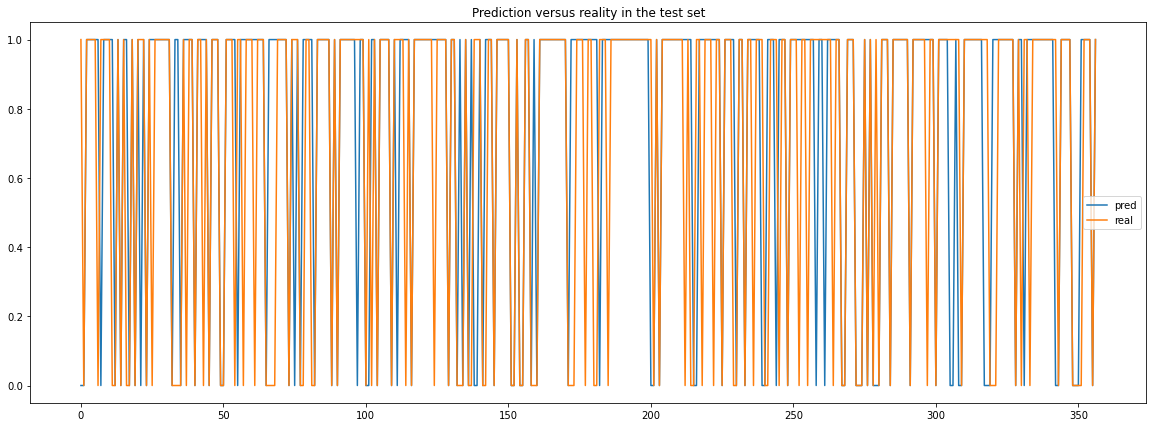

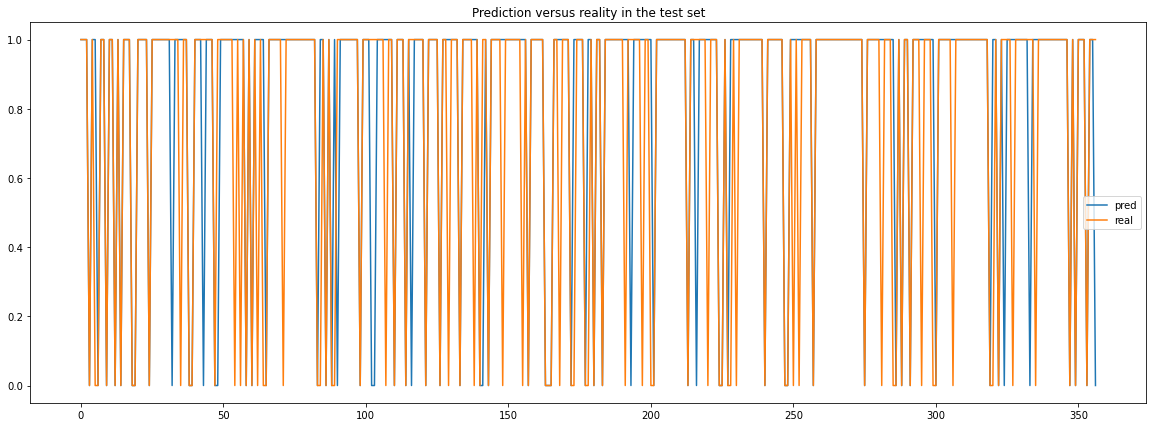

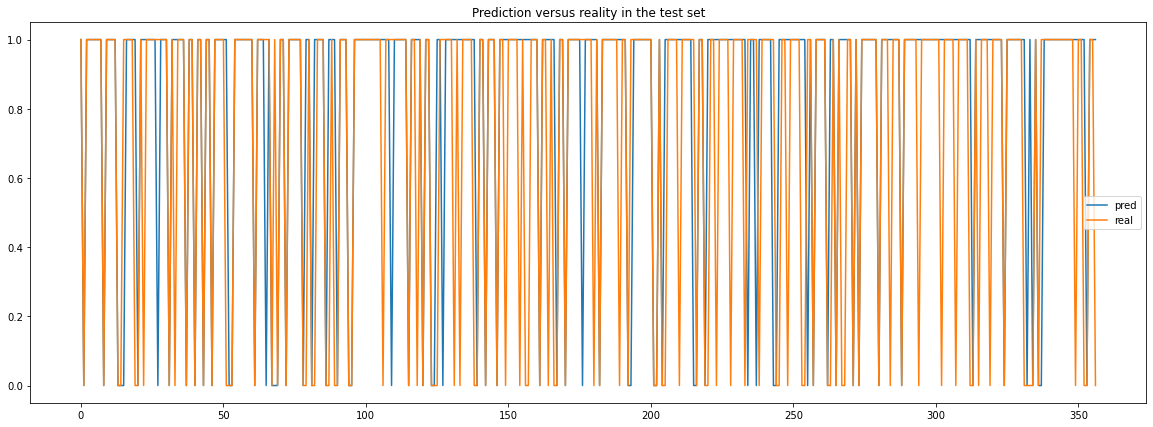

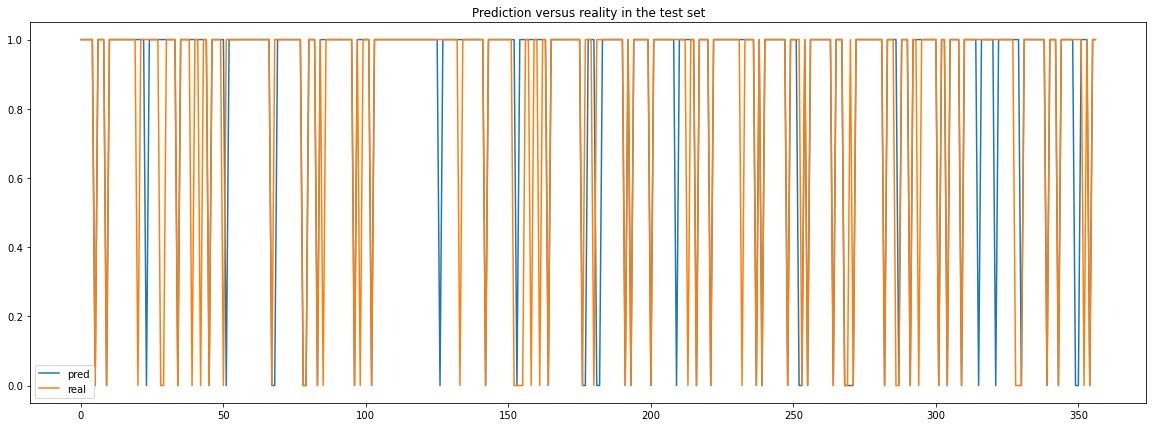

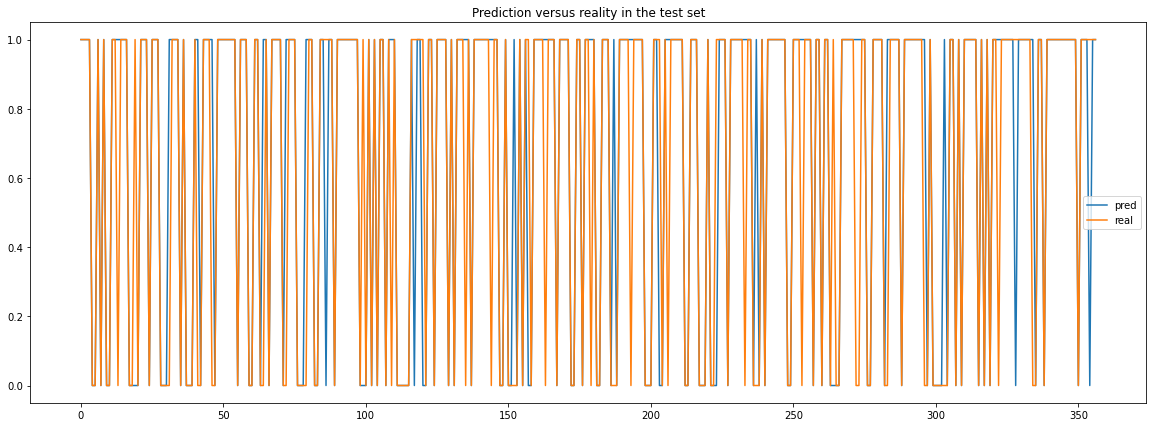

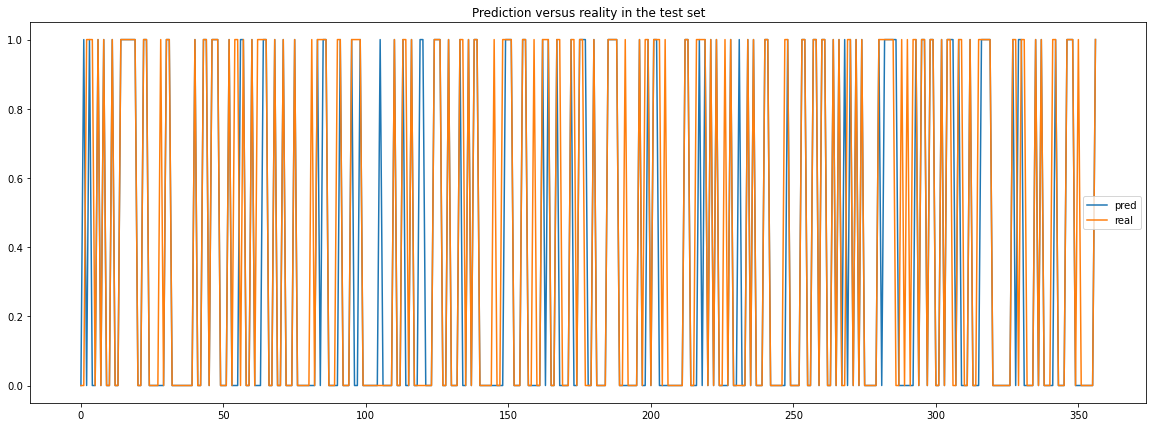

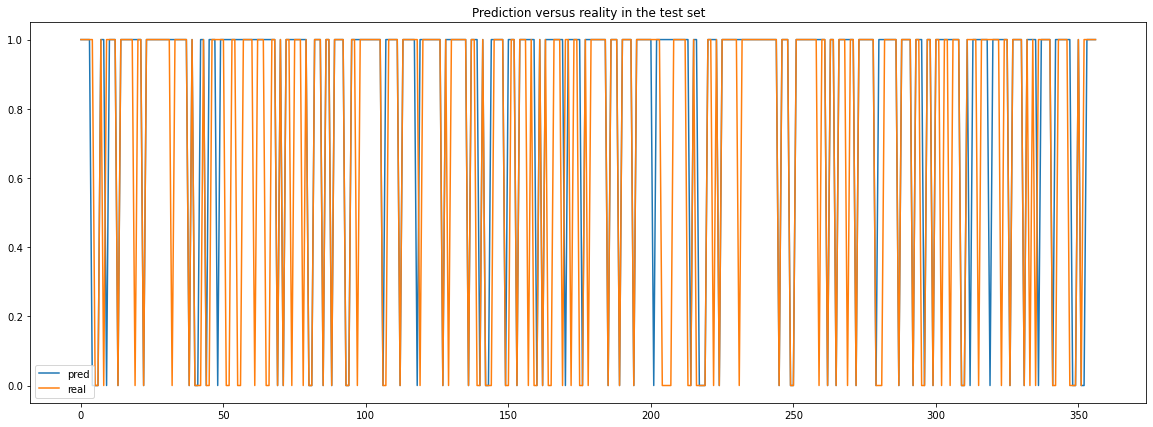

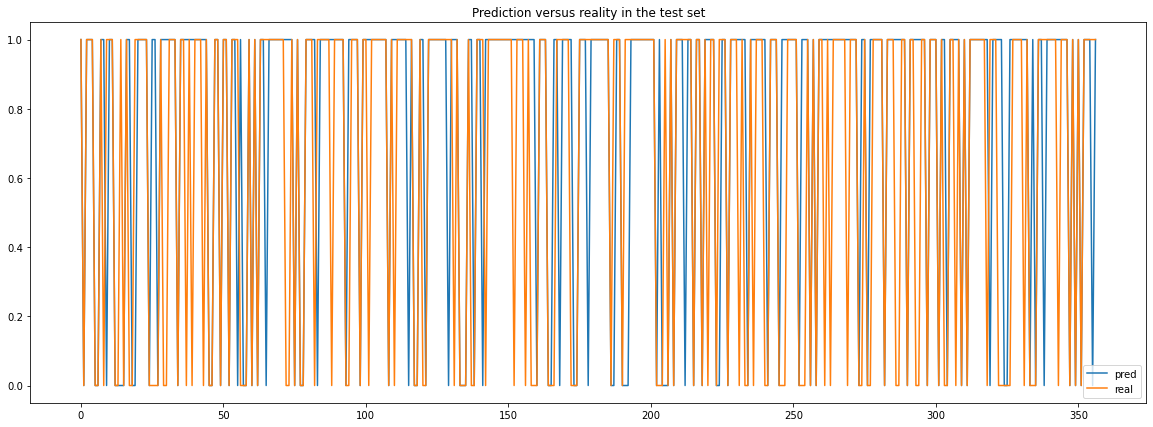

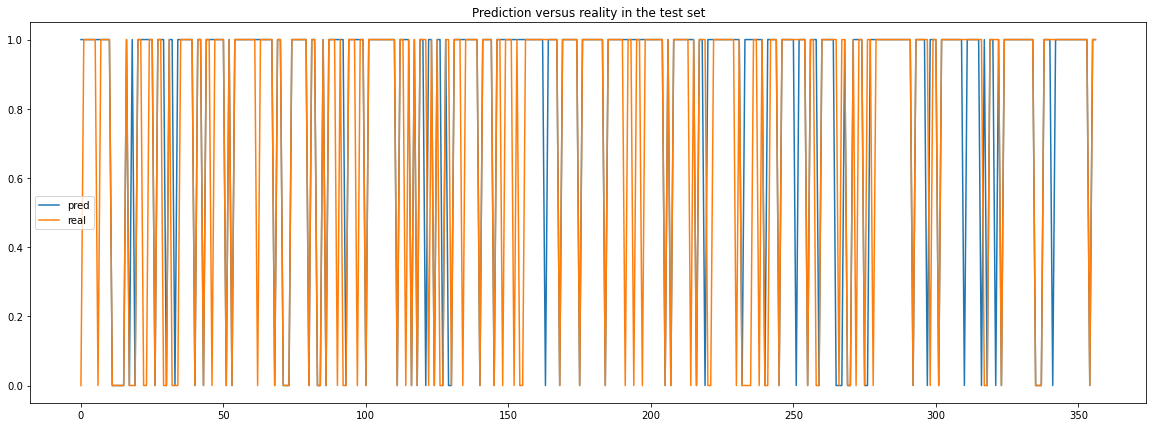

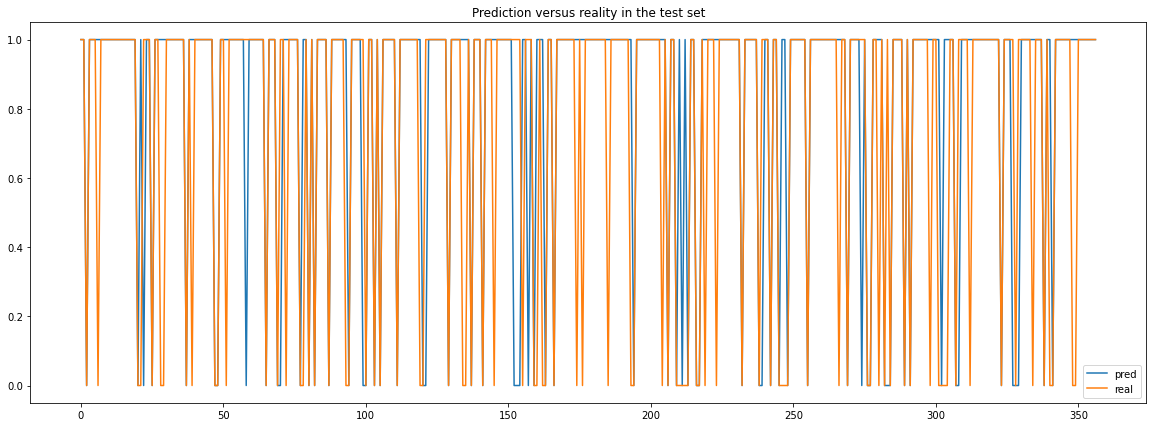

In [6]:
for s in setting.tickers:
    currentStock = stock(s)
    for a in setting.attributeOfInterest:
        currentStock.orig[a] = multpl_stocks[a][s]
    stocksOfInterest[s] = currentStock

for t in setting.tickers:
    s = stocksOfInterest[t]
    s.getAllIndicators()
    s.prepareData(60)
    n = len(s.orig["Open"])
    print("Train Len:",n)
    X = s.X[25:]
    y = s.y[25:]
    trainSize = int(np.ceil(n * 0.8))-1
    trainSetX2 = X[:trainSize]
    trainSetY2 = y[:trainSize]
    testSetX = X[trainSize:]
    testSetY = y[trainSize:]
    trainSetX, testSetX, trainSetY, testSetY = train_test_split(trainSetX2, trainSetY2, train_size = (2*trainSize) // 3)
    print('len X_train', len(trainSetX))
    print('len y_train', len(trainSetY))
    print('len X_test', len(testSetX))
    print('len y_test', len(testSetY))
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=423)
    rf.fit(trainSetX, trainSetY)
    pred = rf.predict(testSetX)
    precision = precision_score(y_pred=pred, y_true=testSetY)
    recall = recall_score(y_pred=pred, y_true=testSetY)
    f1 = f1_score(y_pred=pred, y_true=testSetY)
    accuracy = accuracy_score(y_pred=pred, y_true=testSetY)
    confusion = confusion_matrix(y_pred=pred, y_true=testSetY)
    print(s.name)
    print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
    print('Confusion Matrix')
    print(confusion)

    plt.figure(figsize=(20,7))
    plt.plot(np.arange(len(pred)), pred, label='pred')
    plt.plot(np.arange(len(testSetY)), testSetY, label='real' );
    plt.title('Prediction versus reality in the test set')
    plt.legend()
    
    


    


In [ ]:
for s in setting.tickers:
    currentStock = stock(s)
    for a in setting.attributeOfInterest:
        currentStock.orig[a] = multpl_stocks[a][s]
    stocksOfInterest[s] = currentStock

for t in setting.tickers:
    s = stocksOfInterest[t]
    s.getAllIndicators()
    s.prepareData(60)
    n = len(s.orig["Open"])
    print("Train Len:",n)
    X = s.X[25:]
    y = s.y[25:]
    trainSize = int(np.ceil(setting.trainTestRatio * n)-1)
    trainSetX = X[:trainSize]
    trainSetY = y[:trainSize]
    testSetX = X[trainSize:]
    testSetY = y[trainSize:]
    print('len X_train', len(trainSetX))
    print('len y_train', len(trainSetY))
    print('len X_test', len(testSetX))
    print('len y_test', len(testSetY))
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=423)
    cross_validate
    rf.fit(trainSetX, trainSetY)
    pred = rf.predict(testSetX)
    precision = precision_score(y_pred=pred, y_true=testSetY)
    recall = recall_score(y_pred=pred, y_true=testSetY)
    f1 = f1_score(y_pred=pred, y_true=testSetY)
    accuracy = accuracy_score(y_pred=pred, y_true=testSetY)
    confusion = confusion_matrix(y_pred=pred, y_true=testSetY)
    print(s.name)
    print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
    print('Confusion Matrix')
    print(confusion)
    cv_results = cross_validate(rf, X, y, cv=KFold(n_splits=5))

    plt.figure(figsize=(20,7))
    plt.plot(np.arange(len(pred)), pred, label='pred')
    plt.plot(np.arange(len(testSetY)), testSetY, label='real' );
    plt.title('Prediction versus reality in the test set')
    plt.legend()
    scores = cross_validate(rf, X, y, cv=3,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)
    print("CV:", scores['train_r2'])

In [ ]:
aapl.head()